In [1]:
# import system libs
import os
import itertools

# import data handling tools
import numpy as np
import pandas as pd
import seaborn as sns
sns.set_style('darkgrid')
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

# import Deep learning Libraries
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, GlobalAveragePooling2D, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.applications import EfficientNetB3

# ignore the warnings
import warnings
warnings.filterwarnings('ignore')

In [3]:
# loading the dataset
def loading_the_data(data_dir):
    # Generate data paths with labels
    filepaths = []
    labels = []

    # Get folder names
    folds = os.listdir(data_dir)

    for fold in folds:
        foldpath = os.path.join(data_dir, fold)
        filelist = os.listdir(foldpath)
        for file in filelist:
            fpath = os.path.join(foldpath, file)
            
            filepaths.append(fpath)
            labels.append(fold)

    # Concatenate data paths with labels into one DataFrame
    Fseries = pd.Series(filepaths, name='filepaths')
    Lseries = pd.Series(labels, name='labels')

    df = pd.concat([Fseries, Lseries], axis=1)
    
    return df


# change label names to its original names
def change_label_names(df, column_name):
    index = {'lung_aca': 'Lung_adenocarcinoma', 'lung_n': 'Lung_benign_tissue', 'lung_scc': 'Lung squamous_cell_carcinoma'}


    df[column_name] = df[column_name].replace(index)

In [32]:
# loading the data
# Set the directory path for the dataset
data_dir = r"C:\Users\anant\Downloads\archive (1)"

# Assuming you have a function `loading_the_data` to load data from this path
df = loading_the_data(data_dir)

# If you need to change label names
change_label_names(df, 'labels')

df


filepaths                labels
0  C:\Users\anant\Downloads\archive (1)\lung_colo...  lung_colon_image_set
1  C:\Users\anant\Downloads\archive (1)\lung_colo...  lung_colon_image_set

In [38]:
import os
import pandas as pd

def loading_the_data(data_dir):
    filepaths = []
    labels = []
    
    # Traverse the lung_colon_image_set directory to reach cancer type folders
    for label_dir in os.listdir(data_dir):
        label_path = os.path.join(data_dir, label_dir)
        
        # Check if label_path is a directory (this should be "lung_colon_image_set")
        if os.path.isdir(label_path):
            for sub_label_dir in os.listdir(label_path):
                sub_label_path = os.path.join(label_path, sub_label_dir)
                
                # Check if sub_label_path is a directory (e.g., each cancer type)
                if os.path.isdir(sub_label_path):
                    for filename in os.listdir(sub_label_path):
                        filepaths.append(os.path.join(sub_label_path, filename))
                        labels.append(sub_label_dir)  # Assign the subdirectory name as label
                
    # Create a DataFrame with file paths and labels
    return pd.DataFrame({"filepaths": filepaths, "labels": labels})

# Load the data
data_dir = r"C:\Users\anant\Downloads\archive (1)\lung_colon_image_set"

df = loading_the_data(data_dir)

# Check if data was loaded correctly
print(df.head())
print("Unique labels:", df['labels'].unique())


                                           filepaths     labels
0  C:\Users\anant\Downloads\archive (1)\lung_colo...  colon_aca
1  C:\Users\anant\Downloads\archive (1)\lung_colo...  colon_aca
2  C:\Users\anant\Downloads\archive (1)\lung_colo...  colon_aca
3  C:\Users\anant\Downloads\archive (1)\lung_colo...  colon_aca
4  C:\Users\anant\Downloads\archive (1)\lung_colo...  colon_aca
Unique labels: ['colon_aca' 'colon_n' 'lung_aca' 'lung_n' 'lung_scc']


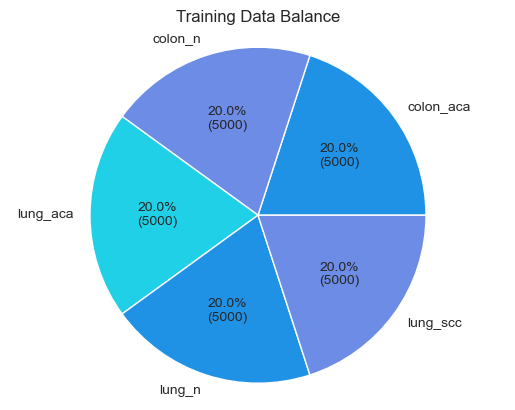

In [40]:
import matplotlib.pyplot as plt

# Data for pie chart
data_balance = df['labels'].value_counts()

# Custom function to display percentage and count on pie chart
def custom_autopct(pct):
    total = sum(data_balance)
    val = int(round(pct * total / 100.0))
    return "{:.1f}%\n({:d})".format(pct, val)

# Pie chart for data balance
plt.pie(data_balance, labels=data_balance.index, autopct=custom_autopct, colors=["#2092E6", "#6D8CE6", "#20D0E6"])
plt.title("Training Data Balance")
plt.axis("equal")  # Equal aspect ratio ensures that pie chart is a circle
plt.show()



In [42]:
# data --> 80% train data && 20% (test, val)
train_df, ts_df = train_test_split(df, train_size = 0.8, shuffle = True, random_state = 42)

# test data --> 10% train data && 10% (test, val)
valid_df, test_df = train_test_split(ts_df, train_size = 0.5, shuffle = True, random_state = 42)

In [44]:
# crobed image size
batch_size = 32
img_size = (224, 224)

tr_gen = ImageDataGenerator(rescale=1. / 255)
ts_gen = ImageDataGenerator(rescale=1. / 255)

train_gen = tr_gen.flow_from_dataframe( train_df, x_col= 'filepaths', y_col= 'labels', target_size= img_size, class_mode= 'categorical',
                                    color_mode= 'rgb', shuffle= True, batch_size= batch_size)

valid_gen = ts_gen.flow_from_dataframe( valid_df, x_col= 'filepaths', y_col= 'labels', target_size= img_size, class_mode= 'categorical',
                                    color_mode= 'rgb', shuffle= True, batch_size= batch_size)

test_gen = ts_gen.flow_from_dataframe( test_df, x_col= 'filepaths', y_col= 'labels', target_size= img_size, class_mode= 'categorical',
                                    color_mode= 'rgb', shuffle= False, batch_size= batch_size)

Found 20000 validated image filenames belonging to 5 classes.
Found 2500 validated image filenames belonging to 5 classes.
Found 2500 validated image filenames belonging to 5 classes.


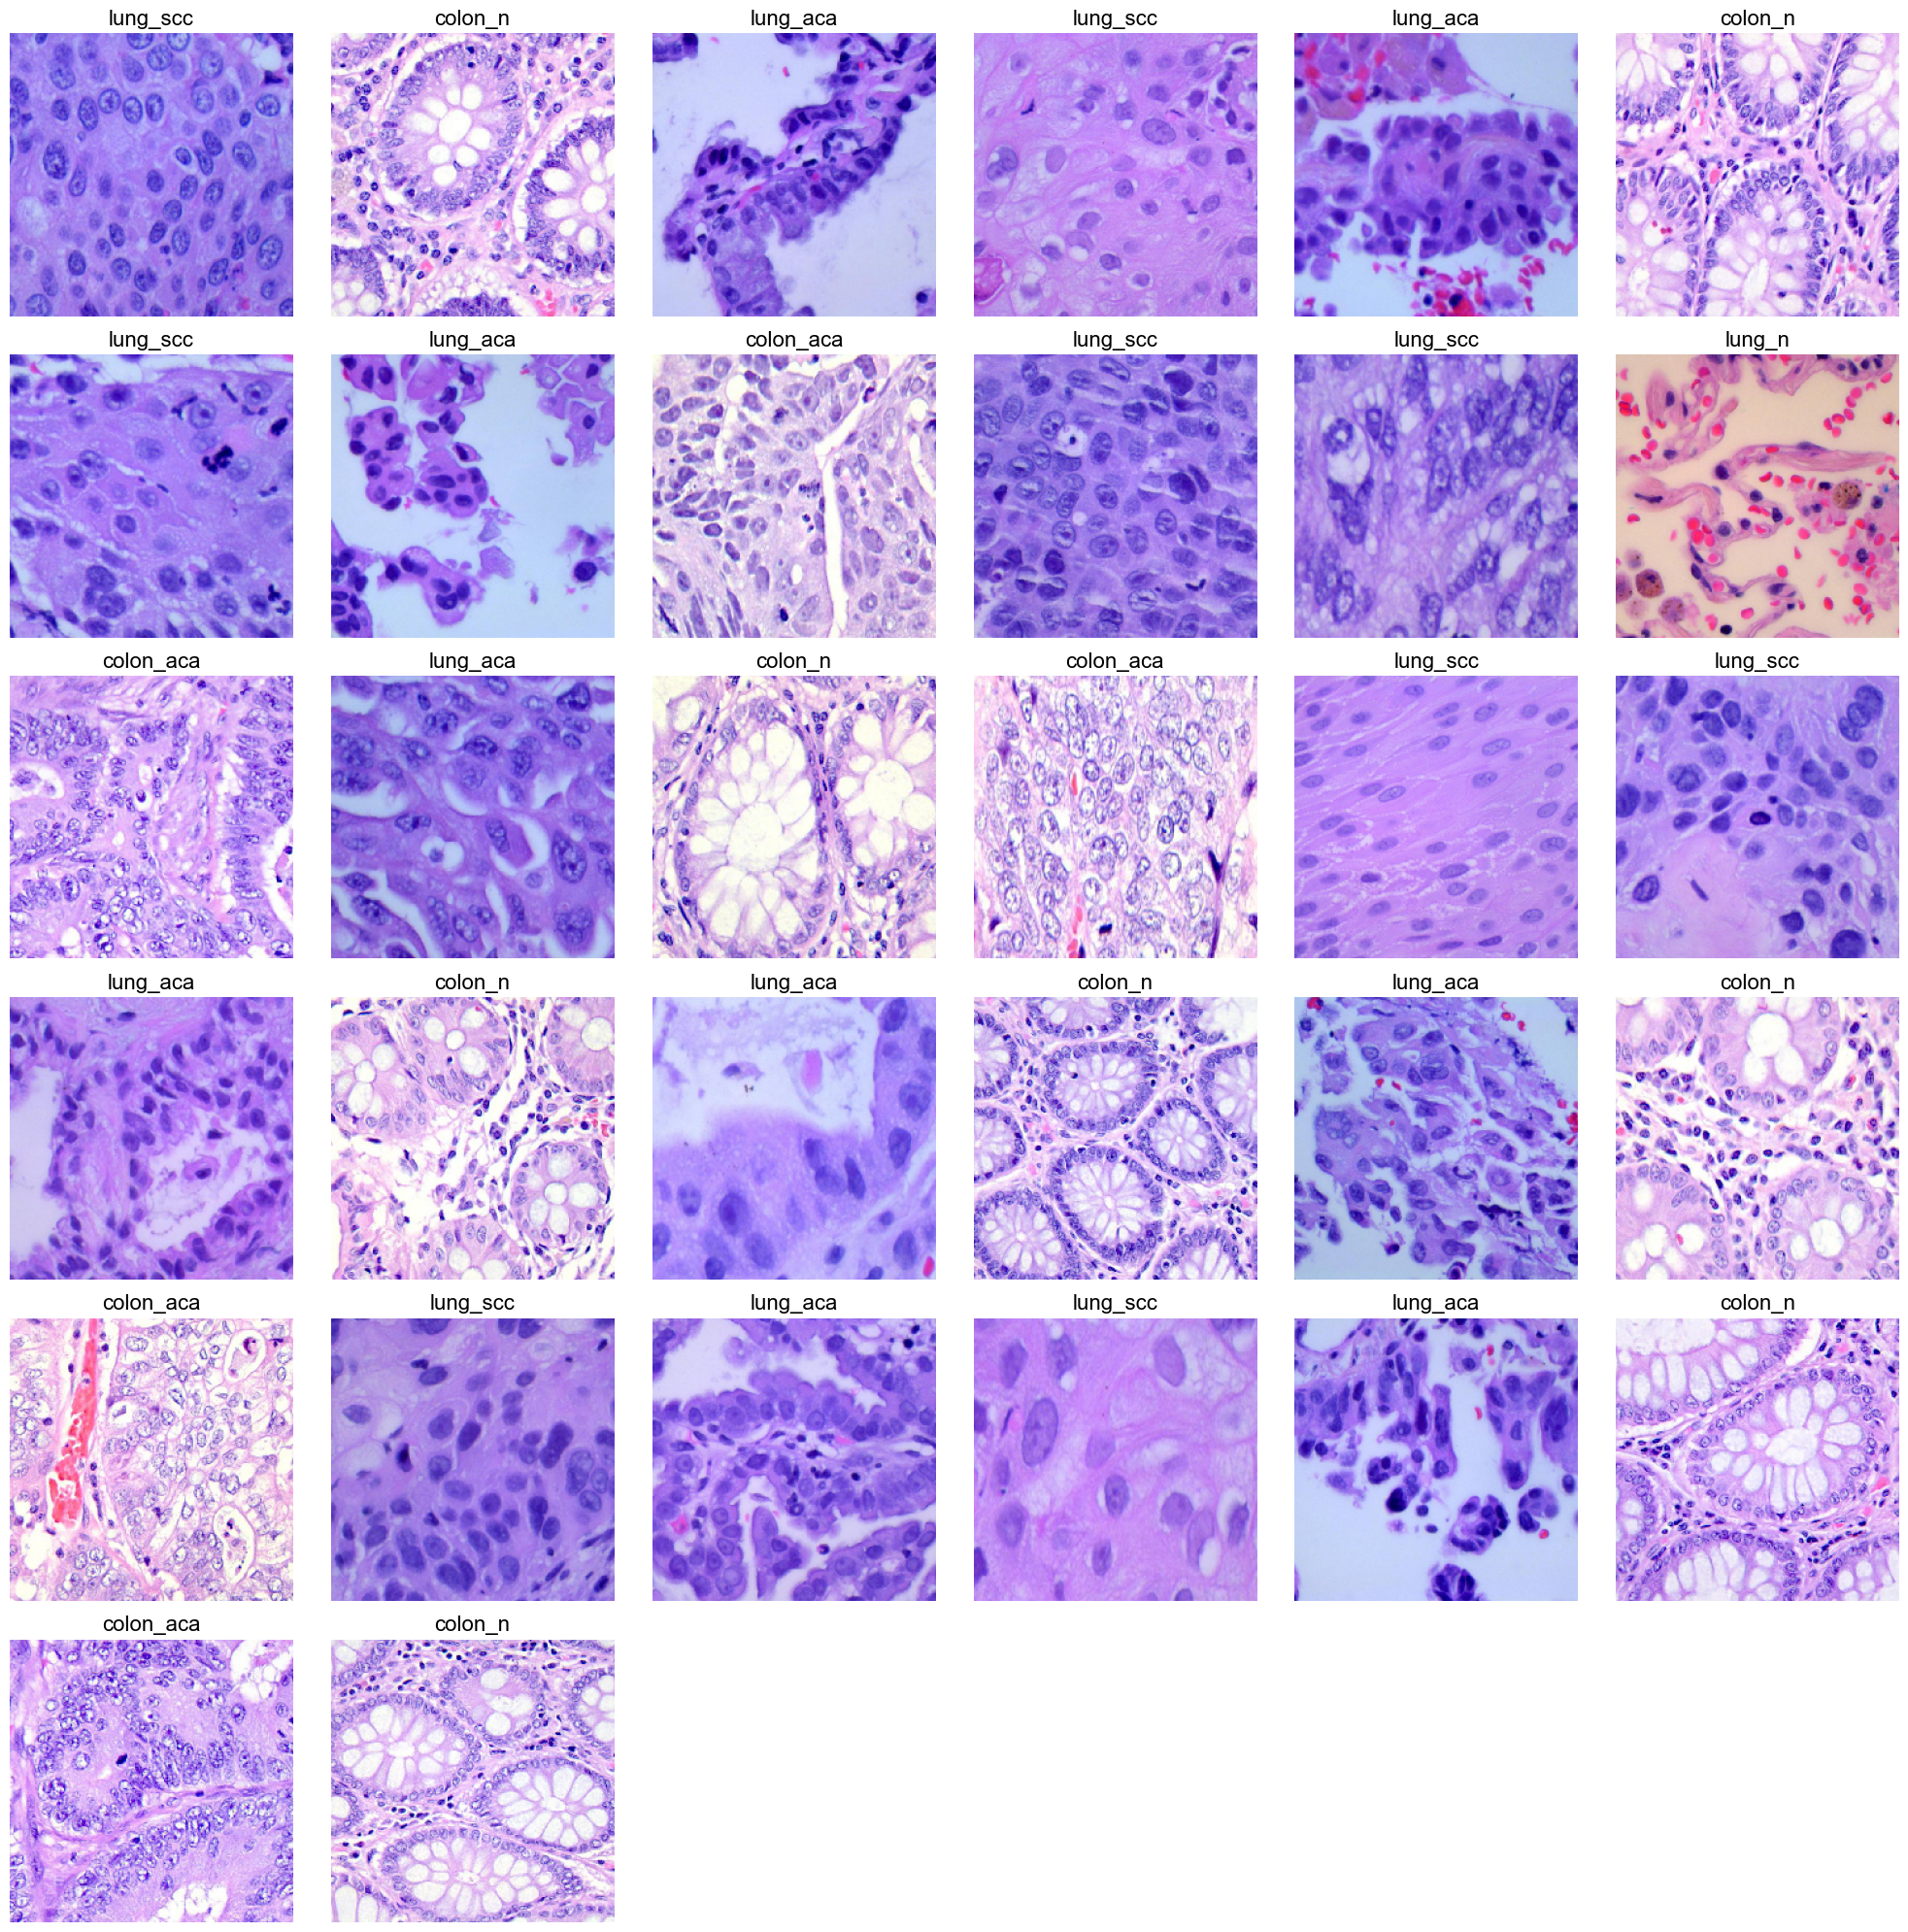

In [46]:
g_dict = train_gen.class_indices      # defines dictionary {'class': index}
classes = list(g_dict.keys())       # defines list of dictionary's kays (classes), classes names : string
images, labels = next(train_gen)      # get a batch size samples from the generator

# ploting the patch size samples
plt.figure(figsize= (20, 20))

for i in range(batch_size):
    plt.subplot(6, 6, i + 1)
    image = images[i]
    plt.imshow(image)
    index = np.argmax(labels[i])  # get image index
    class_name = classes[index]   # get class of image
    plt.title(class_name, color= 'black', fontsize= 16)
    plt.axis('off')
plt.tight_layout()
plt.show()

In [48]:
# Displaying the model performance
def model_performance(history, Epochs):
    # Define needed variables
    tr_acc = history.history['accuracy']
    tr_loss = history.history['loss']
    val_acc = history.history['val_accuracy']
    val_loss = history.history['val_loss']
    
    Epochs = [i+1 for i in range(len(tr_acc))]
    
    # Plot training history
    plt.figure(figsize= (20, 8))
    plt.style.use('fivethirtyeight')
    
    plt.subplot(1, 2, 1)
    plt.plot(Epochs, tr_loss, 'r', label= 'Training loss')
    plt.plot(Epochs, val_loss, 'g', label= 'Validation loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    
    plt.subplot(1, 2, 2)
    plt.plot(Epochs, tr_acc, 'r', label= 'Training Accuracy')
    plt.plot(Epochs, val_acc, 'g', label= 'Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    
    plt.tight_layout
    plt.show()
    

# Evaluate the model
def model_evaluation(model):
    train_score = model.evaluate(train_gen, verbose= 1)
    valid_score = model.evaluate(valid_gen, verbose= 1)
    test_score = model.evaluate(test_gen, verbose= 1)
    
    print("Train Loss: ", train_score[0])
    print("Train Accuracy: ", train_score[1])
    print('-' * 20)
    print("Validation Loss: ", valid_score[0])
    print("Validation Accuracy: ", valid_score[1])
    print('-' * 20)
    print("Test Loss: ", test_score[0])
    print("Test Accuracy: ", test_score[1])
    

# Get Predictions
def get_pred(model, test_gen):
    
    preds = model.predict(test_gen)
    y_pred = np.argmax(preds, axis = 1)
    
    return y_pred


# Confusion Matrix
def plot_confusion_matrix(test_gen, y_pred):
    
    g_dict = test_gen.class_indices
    classes = list(g_dict.keys())
    
    # Display the confusion matrix
    cm = confusion_matrix(test_gen.classes, y_pred)

    plt.figure(figsize= (10, 10))
    plt.imshow(cm, interpolation= 'nearest', cmap= plt.cm.Blues)
    plt.title('Confusion Matrix')
    plt.colorbar()
    
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation= 45)
    plt.yticks(tick_marks, classes)
    
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j], horizontalalignment= 'center', color= 'white' if cm[i, j] > thresh else 'black')
    
    
    plt.tight_layout()
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    
    plt.show()
    
    
# Defining a convolutional NN block for a sequential CNN model
def conv_block(filters, act='relu'):
    
    block = Sequential()
    block.add(Conv2D(filters, 3, activation=act, padding='same'))
    block.add(Conv2D(filters, 3, activation=act, padding='same'))
    block.add(BatchNormalization())
    block.add(MaxPooling2D())
    
    return block


# Defining a dense NN block for a sequential CNN model
def dense_block(units, dropout_rate, act='relu'):
    
    block = Sequential()
    block.add(Dense(units, activation=act))
    block.add(BatchNormalization())
    block.add(Dropout(dropout_rate))
    
    return block

In [50]:
# create Model structure
img_size = (224, 224)
channels = 3
img_shape = (img_size[0], img_size[1], channels)

class_counts = len(list(train_gen.class_indices.keys()))     # to define number of classes in dense layer

In [52]:
# Model architecture
cnn_model = Sequential()

# first conv block
cnn_model.add(Conv2D(filters=16, kernel_size=(3,3), padding="same", activation="relu", input_shape= img_shape))
cnn_model.add(BatchNormalization())
cnn_model.add(MaxPooling2D())

# second conv block
cnn_model.add(conv_block(32))

# third conv block
cnn_model.add(conv_block(64))

# fourth conv bolck
cnn_model.add(conv_block(128))

# fifth conv block
cnn_model.add(conv_block(256))

# flatten layer
cnn_model.add(Flatten())

# first dense block
cnn_model.add(dense_block(128, 0.5))

# second dense block
cnn_model.add(dense_block(64, 0.3))

# third dense block
cnn_model.add(dense_block(32, 0.2))

# output layer
cnn_model.add(Dense(class_counts, activation = "softmax"))

In [54]:
cnn_model.compile(Adamax(learning_rate= 0.001), loss= 'categorical_crossentropy', metrics= ['accuracy'])

cnn_model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 224, 224, 16)   │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 224, 224, 16)   │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 112, 112, 16)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_1 (Sequential)       │ (None, 56, 56, 32)     │        14,016 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_2 (Sequential)       │ (None, 28, 28, 64)     │        55,680 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_3 (Sequential)       │ (None, 14, 14, 128)    │       221,952 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_4 (Sequential)       │ (None, 7, 7, 256)      │       886,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 12544)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_5 (Sequential)       │ (None, 128)            │     1,606,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_6 (Sequential)       │ (None, 64)             │         8,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_7 (Sequential)       │ (None, 32)             │         2,208 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 5)              │           165 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,795,589 (10.66 MB)

 Trainable params: 2,794,149 (10.66 MB)

 Non-trainable params: 1,440 (5.62 KB)

In [60]:
from tensorflow.keras.callbacks import EarlyStopping

# Define the EarlyStopping callback
early_stopping = EarlyStopping(monitor='val_loss',  # You can monitor 'val_loss' or 'val_accuracy'
                               patience=4,           # Number of epochs with no improvement before stopping
                               restore_best_weights=True)  # Restore the best weights when stopped

# Train the model with EarlyStopping
epochs = 20   # Total number of epochs

history = cnn_model.fit(
    train_gen,               # Training data generator
    epochs=epochs,           # Number of epochs
    verbose=1,               # Output verbosity
    validation_data=valid_gen,  # Validation data generator
    shuffle=False,           # Whether to shuffle the training data
    callbacks=[early_stopping]  # Include the EarlyStopping callback
)


Epoch 1/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 796s 1s/step - accuracy: 0.9625 - loss: 0.1210 - val_accuracy: 0.9616 - val_loss: 0.0987
Epoch 2/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 797s 1s/step - accuracy: 0.9668 - loss: 0.1023 - val_accuracy: 0.9844 - val_loss: 0.0485
Epoch 3/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 796s 1s/step - accuracy: 0.9763 - loss: 0.0787 - val_accuracy: 0.9868 - val_loss: 0.0473
Epoch 4/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 798s 1s/step - accuracy: 0.9752 - loss: 0.0818 - val_accuracy: 0.9700 - val_loss: 0.0917
Epoch 5/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 800s 1s/step - accuracy: 0.9831 - loss: 0.0580 - val_accuracy: 0.9804 - val_loss: 0.0589
Epoch 6/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 798s 1s/step - accuracy: 0.9861 - loss: 0.0489 - val_accuracy: 0.9880 - val_loss: 0.0270
Epoch 7/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 801s 1s/step - accuracy: 0.9864 - loss: 0.0451 - val_accuracy: 0.9916 - val_loss: 0.0243
Epoch 8/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 811s 1s/step - accuracy: 0.9888 - loss: 0.0376 - val_accu

In [62]:
# Evaluate the model on the test set after all epochs have completed
test_loss, test_accuracy = cnn_model.evaluate(test_gen, verbose=1)

# Print the final test accuracy
print(f"Final Test Accuracy: {test_accuracy * 100:.2f}%")


79/79 ━━━━━━━━━━━━━━━━━━━━ 30s 381ms/step - accuracy: 0.9920 - loss: 0.0278
Final Test Accuracy: 99.32%


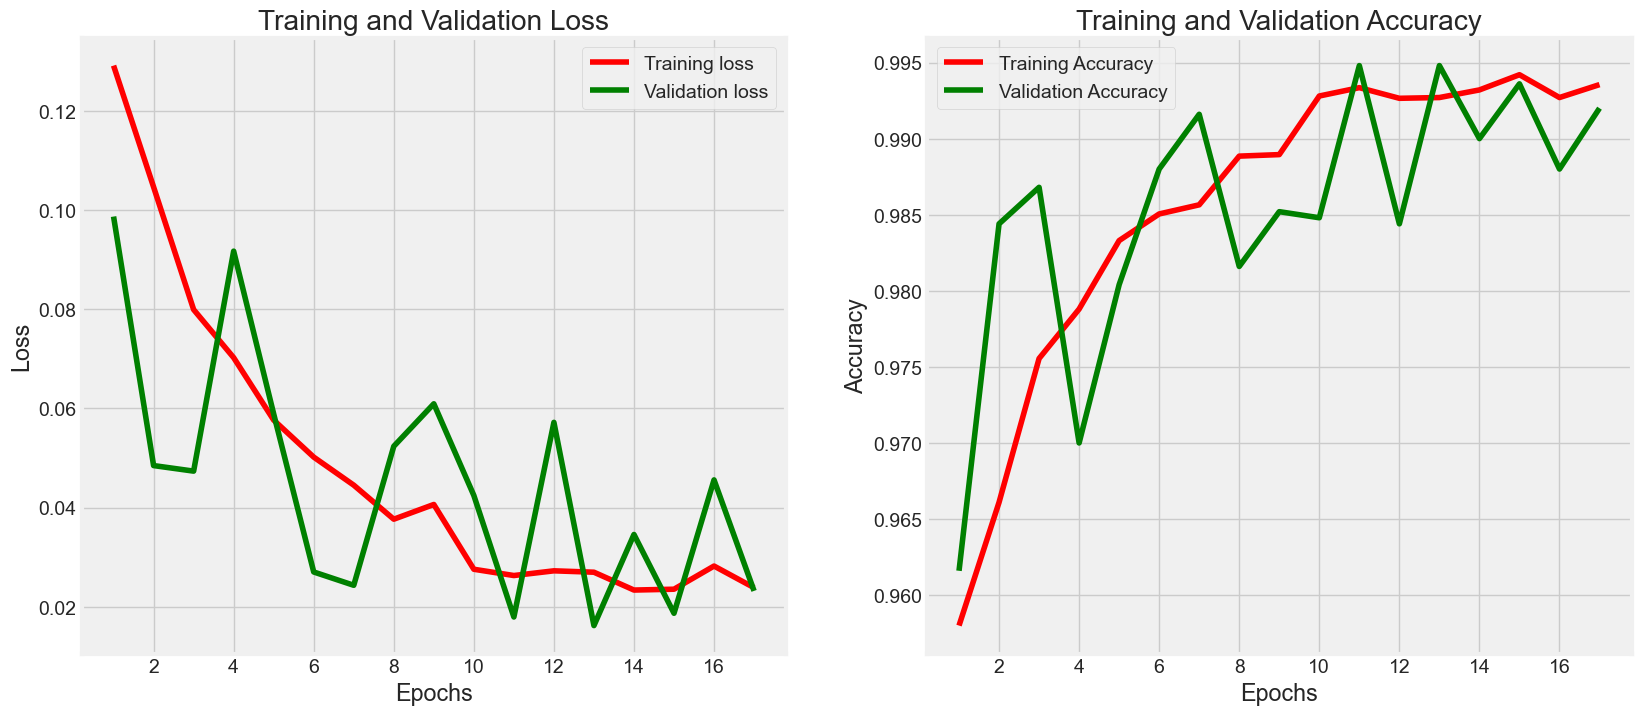

In [64]:
# Display model performance
model_performance(history, epochs)

In [66]:
# Model evaluation
model_evaluation(cnn_model)

625/625 ━━━━━━━━━━━━━━━━━━━━ 248s 396ms/step - accuracy: 0.9992 - loss: 0.0031
79/79 ━━━━━━━━━━━━━━━━━━━━ 32s 407ms/step - accuracy: 0.9957 - loss: 0.0113
79/79 ━━━━━━━━━━━━━━━━━━━━ 35s 441ms/step - accuracy: 0.9920 - loss: 0.0278
Train Loss:  0.0031201911624521017
Train Accuracy:  0.9990000128746033
--------------------
Validation Loss:  0.01620667241513729
Validation Accuracy:  0.9947999715805054
--------------------
Test Loss:  0.020961012691259384
Test Accuracy:  0.9932000041007996


In [76]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten

# Example of defining a simple model
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)),
    Flatten(),
    Dense(64, activation='relu'),
    Dense(1, activation='sigmoid')  # Assuming binary classification (cancerous vs non-cancerous)
])

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model here (or load a pre-trained one)
# model.fit(...)

# Save the model
import os

if not os.path.exists('models'):
    os.makedirs('models')

model.save(os.path.join('models', 'CancerdetectionModel.keras'))


In [78]:
# Check if the folder exists
print(os.path.exists('models'))


True


In [80]:
import os
print(os.getcwd())


C:\Users\anant


In [82]:
from tensorflow.keras.models import load_model
model = load_model('models/CancerdetectionModel.keras')
model.summary()



Model: "sequential_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_10 (Conv2D)              │ (None, 222, 222, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 1577088)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 64)             │   100,933,696 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 302,803,973 (1.13 GB)

 Trainable params: 100,934,657 (385.04 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 201,869,316 (770.07 MB)

In [92]:
from tensorflow.keras.preprocessing import image
import numpy as np

# Load an image (change the path to the image you want to predict)
img_path = r'C:\Users\anant\Downloads\testcancer.jpg'
img = image.load_img(img_path, target_size=(224, 224))  # Resize it to the model's expected input size

# Convert the image to an array
img_array = image.img_to_array(img)

# Expand the dimensions to match the model's input shape (batch_size, height, width, channels)
img_array = np.expand_dims(img_array, axis=0)

# Normalize the image (assuming you normalized your training data)
img_array = img_array / 255.0

# Make a prediction
prediction = model.predict(img_array)

# Print the prediction result
if prediction[0] > 0.5:
    print("Prediction: Cancerous")
else:
    print("Prediction: Non-cancerous")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step
Prediction: Non-cancerous
